# Run GRN construction
**Authorship:** Adam Klie (last updated: 08/01/2023)<br>
***
**Description:** This notebook takes in an h5ad file with raw counts in it and will preprocess it for CellOracle.
***

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import celloracle as co
co.__version__

which: no R in (/cm/local/apps/environment-modules/4.4.0//bin:/cellar/users/aklie/opt/google-cloud-sdk/bin:/cellar/users/aklie/opt/miniconda3/bin:/cellar/users/aklie/opt/miniconda3/condabin:/cellar/users/aklie/opt/meme/bin:/cellar/users/aklie/opt/meme/libexec/meme-5.5.0:/cellar/users/aklie/opt/apache-ant-1.10.12/bin:/cellar/users/aklie/opt/deltasvm_script/deltasvm.pl:/cellar/users/aklie/opt/lsgkm-svr/bin:/cellar/users/aklie/opt/gatk-4.2.6.1:/cellar/users/mpagadal/Programs/PRSICE/PRSice.R:/cellar/users/aklie/opt/plink:/cellar/users/aklie/opt/plink2:/cellar/users/aklie/opt/confusion_matrix:/cellar/users/aklie/bin/motif_finding.sh:/cellar/users/aklie/opt/edirect:/cellar/users/aklie/opt/ucsc:/cellar/users/mpagadal/Programs/bcftools-1.11:/cellar/users/aklie/opt/homer/bin:/cellar/users/aklie/opt/Gene2vec/src:/cellar/users/aklie/opt:/cellar/users/aklie/.local/bin:/cellar/users/aklie/opt/cellranger-7.1.0:/cellar/users/aklie/opt/ml4gland/basenji/bin:/cm/local/apps/jupyter-submit:/cm/shared/apps

'0.14.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [32]:
save_folder = "/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results/igvf_b01_LeftCortex/"
os.makedirs(save_folder, exist_ok=True)

# Load data

In [15]:
#adata_path = "/cellar/users/aklie/data/igvf/topic_grn_links/h5ad/igvf_b01_LeftCortex/0.05/Microglia/Microglia_processed_filtered.h5ad"
adata_path = "/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results/igvf_b01_LeftCortex/Microglia_scRNA_prep_v1.h5ad"

In [36]:
adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 3251 × 3661
    obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log_counts'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Genotype_colors', 'Sex_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sublibrary_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_normalized_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [37]:
# Random downsampling into 30K cells if the anndata object include more than 30 K cells.
n_cells_downsample = 30000
if adata.shape[0] > n_cells_downsample:
    
    # Let's dowmsample into 30K cells
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123)

In [38]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :3251
Gene number is :3661


In [39]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
#base_GRN = co.data.load_mouse_promoter_base_GRN()

# Make Oracle object

In [40]:
# Instantiate Oracle object
oracle = co.Oracle()

In [41]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log_counts']
Dimensional reduction:  ['X_pca', 'X_umap']


In [42]:
# In this notebook, we use the unscaled mRNA count for the input of Oracle object.
adata.X = adata.layers["raw_counts"].copy()

In [43]:
# Instantiate Oracle object.
#oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="Kit", embedding_name="X_umap")
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="Genotype", embedding_name="X_umap")

In [44]:
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [45]:
# Perform PCA
oracle.perform_PCA()

12


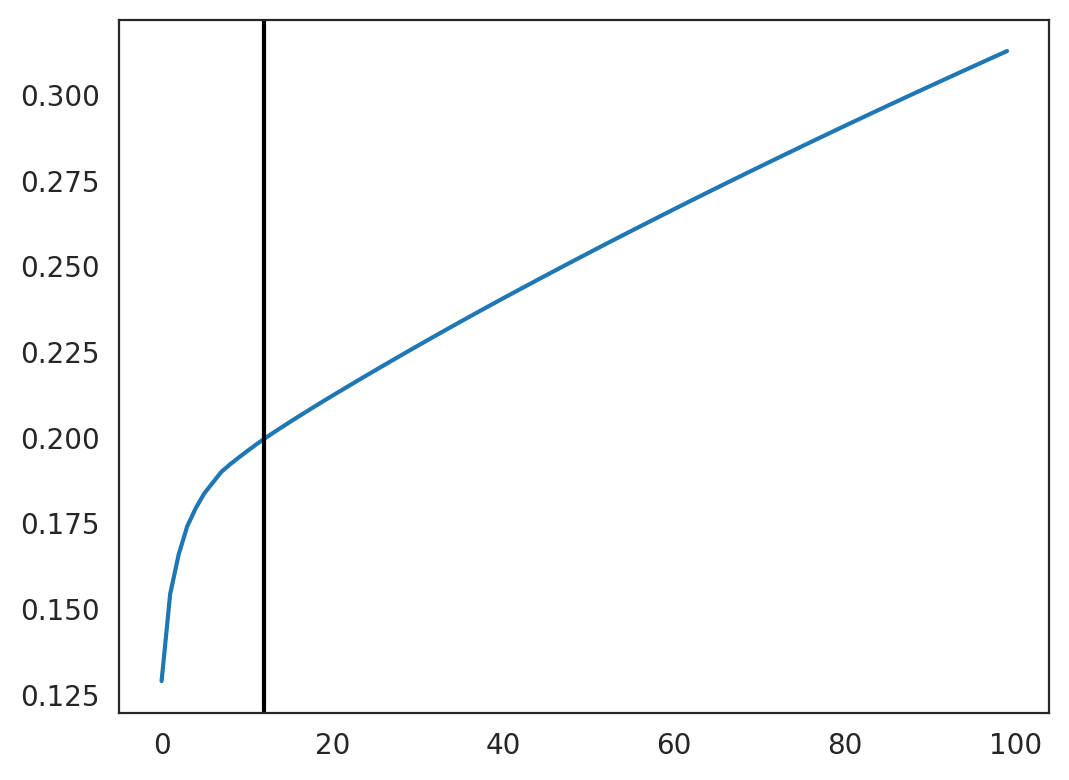

In [46]:
# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_) > 0.2))[0][0]
print(n_comps)
plt.axvline(n_comps, c="k")
plt.show()
n_comps = min(n_comps, 50)

In [47]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :3251


In [48]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :81


In [49]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)

In [50]:
# Save oracle object.
oracle.to_hdf5(os.path.join(save_folder, "pre_grn_construction.celloracle_v1_kit.oracle"))

ValueError: Filename needs to end with '.celloracle.oracle'

# GRN calculation

In [ ]:
# Round trip
#oracle = co.load_hdf5(os.path.join(save_folder, "pre_grn_construction.celloracle.oracle"))

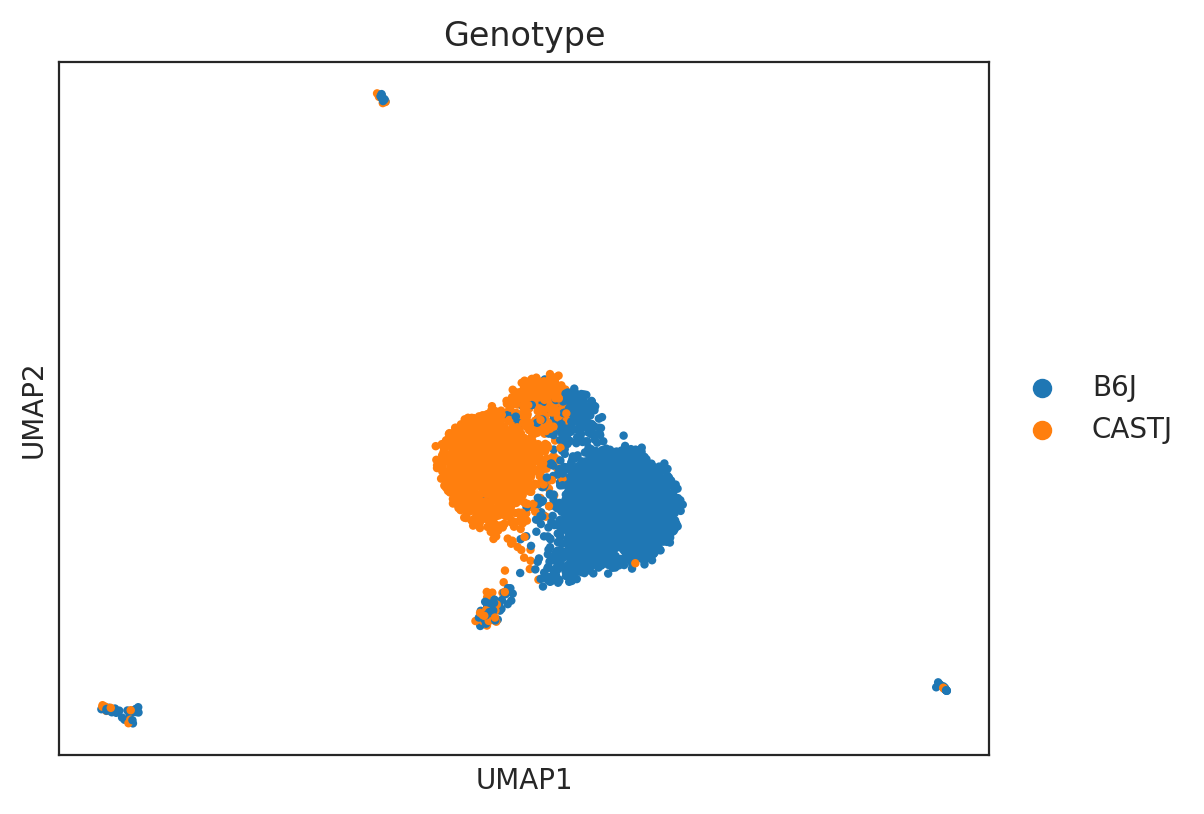

In [51]:
# Check clustering data
sc.pl.umap(oracle.adata, color="Genotype")

In [52]:
genotype_links = oracle.get_links(cluster_name_for_GRN_unit="Genotype", alpha=10, verbose_level=10)

  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for B6J...


  0%|          | 0/3206 [00:00<?, ?it/s]

Inferring GRN for CASTJ...


  0%|          | 0/3206 [00:00<?, ?it/s]

In [33]:
adj = genotype_links.links_dict["WT_v2"]

In [34]:
adj.to_csv(os.path.join(save_folder, "both_adj.tsv"), sep="\t", index=False)

In [ ]:
b6j_adj = genotype_links.links_dict["B6J"]
castj_adj = genotype_links.links_dict["CASTJ"]

In [ ]:
b6j_adj.to_csv(os.path.join(save_folder, "B6J_adj.tsv"), sep="\t", index=False)
castj_adj.to_csv(os.path.join(save_folder, "CASTJ_adj.tsv"), sep="\t", index=False)

In [18]:
cross_genotype_links = oracle.get_links(cluster_name_for_GRN_unit=None, alpha=10, verbose_level=10)

  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for B6J...


  0%|          | 0/3206 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
links.links_dict.keys()

dict_keys(['B6J', 'CASTJ'])

In [44]:
links.links_dict["B6J"].to_csv(os.path.join(save_folder, "Microglia_B6J_links.csv"), index=False)
links.links_dict["CASTJ"].to_csv(os.path.join(save_folder, "Microglia_CASTJ_links.csv"), index=False)

In [45]:
# Save Links object.
links.to_hdf5(file_path=os.path.join(save_folder, "Microglia_links.celloracle.links"))

# DONE!

---

# Scratch